In [ ]:
!pip install unrar rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 65.9 MB/s eta 0:00:00


In [ ]:
!unrar x '/content/drive/MyDrive/AMAZON.rar'


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/AMAZON.rar

Creating    AMAZON                                                    OK
Creating    AMAZON/Test                                               OK
Creating    AMAZON/Test/image                                         OK
Extracting  AMAZON/Test/image/S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_01_06.tif       0%  OK 
Extracting  AMAZON/Test/image/S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_04_19.tif       0%  OK 
Extracting  AMAZON/Test/image/S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_08_03.tif       0%  OK 
Extracting  AMAZON/Test/image/S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_19_09.tif       0%  OK 
Extracting  AMAZON/Test/image/S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_20200217T160045_01_20.tif       0%  OK 
Extracting  AMAZON/Test/image/S2A_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.rmtree('AMAZON')

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import os
import rasterio
from skimage.transform import resize
import random

In [2]:
IMG_WIDTH=256
IMG_HEIGHT=256
IMG_CHANNELS=4

In [3]:
TRAIN_PATH='/content/AMAZON/Training/image'
TEST_PATH='/content/AMAZON/Test/image'
MASK_PATH='/content/AMAZON/Training/label'

train_ids=next(os.walk(TRAIN_PATH))[2]
test_ids=next(os.walk(TEST_PATH))[2]
mask_ids=next(os.walk(MASK_PATH))[2]

X_train=np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
Y_train=np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,1))
X_test=np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))

In [6]:
def load_train_set(train_ids, X_train, path,type:None):
    temp=np.empty(X_train.shape)
    if type=='mask':
      for n, id_ in enumerate(train_ids):
          with rasterio.open(path + '/' + id_) as src:
              all_bands = src.read()
              resized_bands = np.array([resize(band, (256,256), preserve_range=True) for band in all_bands])
              binary_mask = (resized_bands > 0.5).astype(np.float32)  # Adjust the threshold as needed
              temp[n] = binary_mask.T
    else:
      for n, id_ in enumerate(train_ids):
          with rasterio.open(path + '/' + id_) as src:
              all_bands = src.read()
              resized_bands = np.array([resize(band, (256,256), preserve_range=True) for band in all_bands])
              all_bands_normalized = (resized_bands - resized_bands.min(axis=(1, 2), keepdims=True)) / \
                                      (resized_bands.max(axis=(1, 2), keepdims=True) - resized_bands.min(axis=(1, 2), keepdims=True))
              # all_bands_normalized = (all_bands - all_bands.min(axis=(1, 2), keepdims=True)) / \
              #                       (all_bands.max(axis=(1, 2), keepdims=True) - all_bands.min(axis=(1, 2), keepdims=True))
              temp[n]=all_bands_normalized.T
    return(temp)



In [7]:
X_train=load_train_set(train_ids,X_train,TRAIN_PATH,'test')
Y_train=load_train_set(mask_ids,Y_train,MASK_PATH,'mask')
X_test=load_train_set(test_ids,X_train,TEST_PATH,'test')

In [8]:
inputs=tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
c1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(inputs)
c1=tf.keras.layers.Dropout(0.1)(c1)
c1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
c1=tf.keras.layers.Dropout(0.1)(c1)
p1=tf.keras.layers.MaxPooling2D((2,2))(c1)

c2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2=tf.keras.layers.Dropout(0.1)(c2)
c2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
c2=tf.keras.layers.Dropout(0.1)(c2)
p2=tf.keras.layers.MaxPooling2D((2,2))(c2)

c3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3=tf.keras.layers.Dropout(0.1)(c3)
c3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
c3=tf.keras.layers.Dropout(0.1)(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

c4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4=tf.keras.layers.Dropout(0.1)(c4)
c4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
c4=tf.keras.layers.Dropout(0.1)(c4)
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)

c5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5=tf.keras.layers.Dropout(0.1)(c5)
c5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
c5=tf.keras.layers.Dropout(0.1)(c5)
p5=tf.keras.layers.MaxPooling2D((2,2))(c5)

u6=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
u6=tf.keras.layers.concatenate([u6,c4])
c6=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6=tf.keras.layers.Dropout(0.1)(c6)
c6=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

u7=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
u7=tf.keras.layers.concatenate([u7,c3])
c7=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7=tf.keras.layers.Dropout(0.1)(c7)
c7=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

u8=tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8=tf.keras.layers.concatenate([u8,c2])
c8=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8=tf.keras.layers.Dropout(0.1)(c8)
c8=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

u9=tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9=tf.keras.layers.concatenate([u9,c1])
c9=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9=tf.keras.layers.Dropout(0.1)(c9)
c9=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

outputs=tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)

model=tf.keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            592 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 256, 16)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ dropout_3[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ dropout_5[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├──────────────────────

 Total params: 1,986,369 (7.58 MB)

 Trainable params: 1,986,369 (7.58 MB)

 Non-trainable params: 0 (0.00 B)

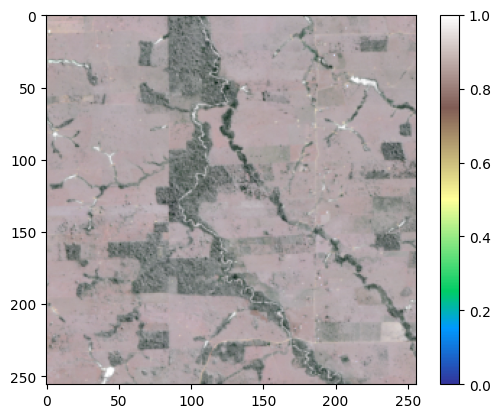

In [9]:
plt.imshow(X_train[0],cmap='terrain')
plt.colorbar()

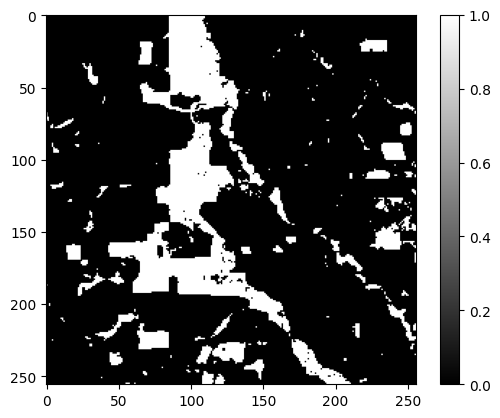

In [10]:
plt.imshow(Y_train[0],cmap='binary_r')
plt.colorbar()

In [11]:
checkpointer=tf.keras.callbacks.ModelCheckpoint('model_for_deforestation.keras',verbose=1,save_best_only=True)

callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

results=model.fit(X_train,Y_train,validation_split=0.1,batch_size=10,epochs=25,callbacks=callbacks)

Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 69s 775ms/step - accuracy: 0.6797 - loss: 0.6024 - val_accuracy: 0.8539 - val_loss: 0.3752
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.8817 - loss: 0.3058 - val_accuracy: 0.8913 - val_loss: 0.2818
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.8965 - loss: 0.2622 - val_accuracy: 0.8902 - val_loss: 0.2949
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9045 - loss: 0.2412 - val_accuracy: 0.9003 - val_loss: 0.2561
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9084 - loss: 0.2305 - val_accuracy: 0.9019 - val_loss: 0.2546
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9127 - loss: 0.2248 - val_accuracy: 0.8890 - val_loss: 0.2815
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9068 - loss: 0.2377 - val_accuracy: 0.9028 - val_loss: 0.2492
Epoch 8/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9208 - loss: 0.1997 - val_accuracy: 0.9116 -

In [12]:
pred_train=model.predict(X_train[:int(X_train.shape[0]*0.9)],verbose=1)
pred_val=model.predict(X_train[int(X_train.shape[0]*0.9):],verbose=1)
pred_test=model.predict(X_test,verbose=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 450ms/step


In [13]:
pred_train_t=(pred_train>0.5).astype('int')
pred_val_t=(pred_val>0.5).astype('int')
pred_test_t=(pred_test>0.5).astype('int')


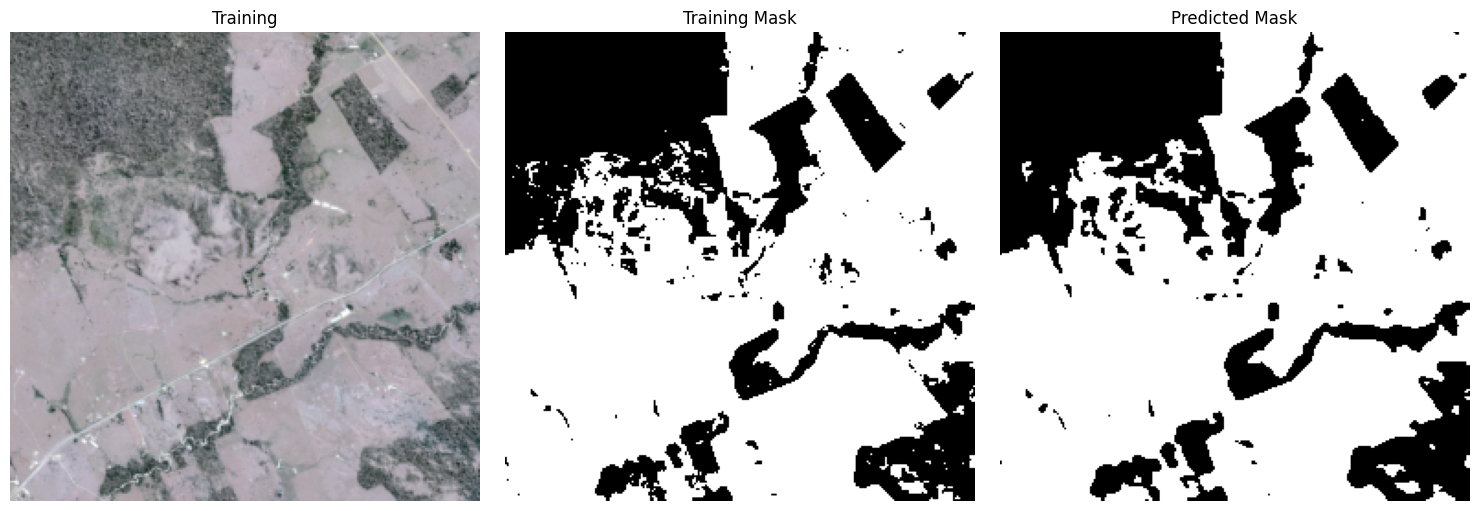

In [16]:
ix = random.randint(0, len(pred_train_t))
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(X_train[ix])
axes[0].set_title('Training')
axes[0].axis('off')
axes[1].imshow(Y_train[ix], cmap='binary')
axes[1].set_title('Training Mask')
axes[1].axis('off')
axes[2].imshow(pred_train_t[ix], cmap='binary')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')
plt.tight_layout()
plt.show()

In [18]:
model.save('model_for_deforestation.keras')